In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms, datasets, models

In [2]:
# define global variables
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print(f"using {DEVICE}")
EPOCHS = 50
BATCH_SIZE = 20

using cuda


In [3]:
# data preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
trainset = datasets.ImageFolder(root='./data/Candlesticks/coin_Bitcoin/20days/ohlc/train',
transform=transform)
testset = datasets.ImageFolder(root='./data/Candlesticks/coin_Bitcoin/20days/ohlc/test',
transform=transform)

train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
)
test_loader = data.DataLoader(
    dataset = testset,
    batch_size = BATCH_SIZE,
    shuffle = True,
)

In [4]:
class ConvNet(nn.Module):
    def __init__(self, n_classes=2):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(10),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(20),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(20*61*61, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(64, n_classes),
        )
    
    def forward(self, x):
        x = self.model(x)
        return x

In [5]:
def vgg16_bn(pretrained=False):
    model = models.vgg16_bn(pretrained=pretrained)
    for param in model.features.parameters():
        param.require_grad = False

    num_features = model.classifier[6].in_features
    features = list(model.classifier.children())[:-1]
    features.extend([nn.Linear(num_features, 2)])
    model.classifier = nn.Sequential(*features)

    return model


In [6]:
def resnet18(pretrained=False):
    model = models.resnet18(pretrained=pretrained)
    for param in model.parameters():
        param.requires_grad = False
    
    num_features = model.fc.in_features
    features = list(model.fc.children())[:-1]
    features.extend([nn.Linear(num_features, 2)])
    model.fc = nn.Sequential(*features)

    return model

In [7]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

In [8]:
def evaluate(model, train_loader, test_loader):
    model.eval()
    train_loss = 0.
    test_loss = 0.
    train_correct = 0.
    test_correct = 0.
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            train_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            train_correct += pred.eq(target.view_as(pred)).sum().item()

        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            test_correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = 100.*train_correct / len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    test_acc = 100.*test_correct / len(test_loader.dataset)
    return train_loss, train_acc, test_loss, test_acc

In [9]:
# model = ConvNet(n_classes=2)
# model = resnet18()
# model = models.vgg16_bn()
model = vgg16_bn(pretrained=True)

print(model)
model = model.to(DEVICE)
#optimizer = optim.Adadelta(model.parameters(), lr=0.1, rho=0.9, eps=1e-06, weight_decay=0.0005)
optimizer = optim.Adadelta(model.parameters(), lr=0.1)
#optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.05)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [12]:
history = dict()
history["train_loss"] = list()
history["train_acc"] = list()
history["test_loss"] = list()
history["test_acc"] = list()

for epoch in range(EPOCHS): 
    train(model, train_loader, optimizer)
    scheduler.step()
    train_loss, train_acc, test_loss, test_acc = evaluate(model, train_loader, test_loader)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
        
    print(f"[{epoch}] Train Loss: {round(train_loss, 4)}, Test Loss: {round(test_loss, 4)}, Accuracy: {round(test_acc, 2)}")
torch.save(model.state_dict(), "models/vgg16_bn.pk")
print('Finished Training')

[0] Train Loss: 0.6914, Test Loss: 0.7025, Accuracy: 51.91
[1] Train Loss: 0.6785, Test Loss: 0.6954, Accuracy: 53.01
[2] Train Loss: 0.6524, Test Loss: 0.7019, Accuracy: 53.01
[3] Train Loss: 0.8873, Test Loss: 1.0782, Accuracy: 49.18
[4] Train Loss: 0.7484, Test Loss: 0.7993, Accuracy: 51.37
[5] Train Loss: 0.655, Test Loss: 0.7322, Accuracy: 50.55
[6] Train Loss: 1.2822, Test Loss: 1.6506, Accuracy: 48.09
[7] Train Loss: 0.5436, Test Loss: 0.8257, Accuracy: 51.64
[8] Train Loss: 0.7296, Test Loss: 1.2395, Accuracy: 51.64
[9] Train Loss: 1.2207, Test Loss: 1.9209, Accuracy: 52.46
[10] Train Loss: 0.1575, Test Loss: 1.1132, Accuracy: 52.46
[11] Train Loss: 0.0828, Test Loss: 1.334, Accuracy: 51.91
[12] Train Loss: 0.0514, Test Loss: 1.5668, Accuracy: 54.64
[13] Train Loss: 0.0293, Test Loss: 1.7537, Accuracy: 55.19
[14] Train Loss: 0.0229, Test Loss: 1.9786, Accuracy: 53.55
[15] Train Loss: 0.0132, Test Loss: 2.0636, Accuracy: 53.28
[16] Train Loss: 0.0093, Test Loss: 2.1351, Accuracy

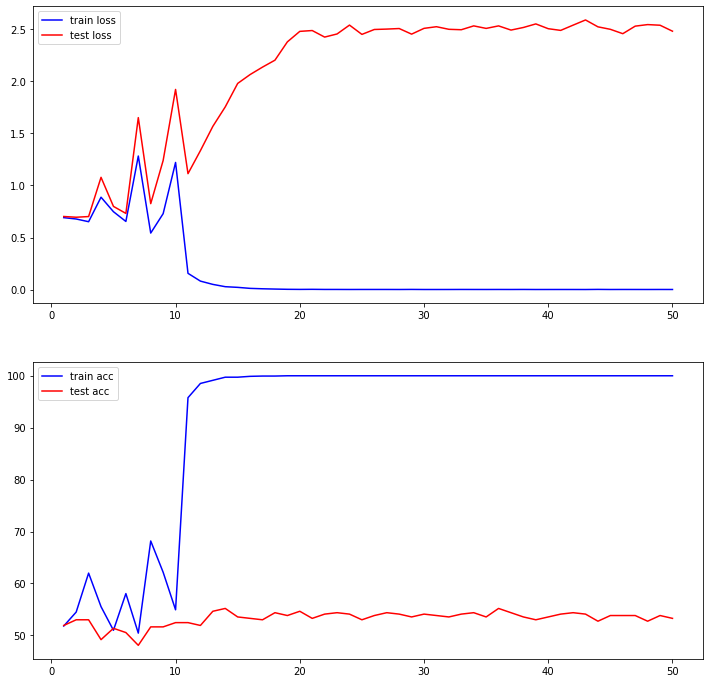

In [13]:
epochs = np.arange(1, EPOCHS+1)
train_loss = np.array(history['train_loss'])
test_loss = np.array(history['test_loss'])
train_acc = np.array(history['train_acc'])
test_acc = np.array(history['test_acc'])

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, "b", label="train loss")
plt.plot(epochs, test_loss, "r", label="test loss")
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc, "b", label="train acc")
plt.plot(epochs, test_acc, "r", label="test acc")
plt.legend(loc='best')

In [15]:
model = vgg16_bn()
model.load_state_dict(torch.load("models/vgg16_bn.pk"))
model.eval()

for data, target in test_loader:
    sigmoid = nn.Sigmoid()
    output = sigmoid(model(data))
    output = output[:, 1]
    # pred = output.max(1, keepdim=True)[1]
    print(output)
    # print(pred)
    # print(target.view_as(pred))
    break

tensor([0.9961, 0.0277, 0.8805, 0.9663, 0.9778, 0.9519, 0.9725, 0.0224, 0.9397,
        0.8960, 0.0011, 0.9477, 0.0322, 0.5846, 0.2561, 0.9994, 0.6681, 0.0818,
        0.9605, 0.3114], grad_fn=<SelectBackward>)
